In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [27]:
Krimize = Path(r'Kirmizi_Pistachio')
Siirt = Path(r'Siirt_Pistachio')

In [28]:
Krimize_images = list(Krimize.glob('*.jpg'))
Siirt_images = list(Siirt.glob('*.jpg'))

In [29]:
Krimize_images[:5]

[WindowsPath('Kirmizi_Pistachio/kirmizi (1).jpg'),
 WindowsPath('Kirmizi_Pistachio/kirmizi (10).jpg'),
 WindowsPath('Kirmizi_Pistachio/kirmizi (11).jpg'),
 WindowsPath('Kirmizi_Pistachio/kirmizi (12).jpg'),
 WindowsPath('Kirmizi_Pistachio/kirmizi (13).jpg')]

In [30]:
Siirt_images[:5]

[WindowsPath('Siirt_Pistachio/siirt (1).jpg'),
 WindowsPath('Siirt_Pistachio/siirt (10).jpg'),
 WindowsPath('Siirt_Pistachio/siirt (11).jpg'),
 WindowsPath('Siirt_Pistachio/siirt (12).jpg'),
 WindowsPath('Siirt_Pistachio/siirt (13).jpg')]

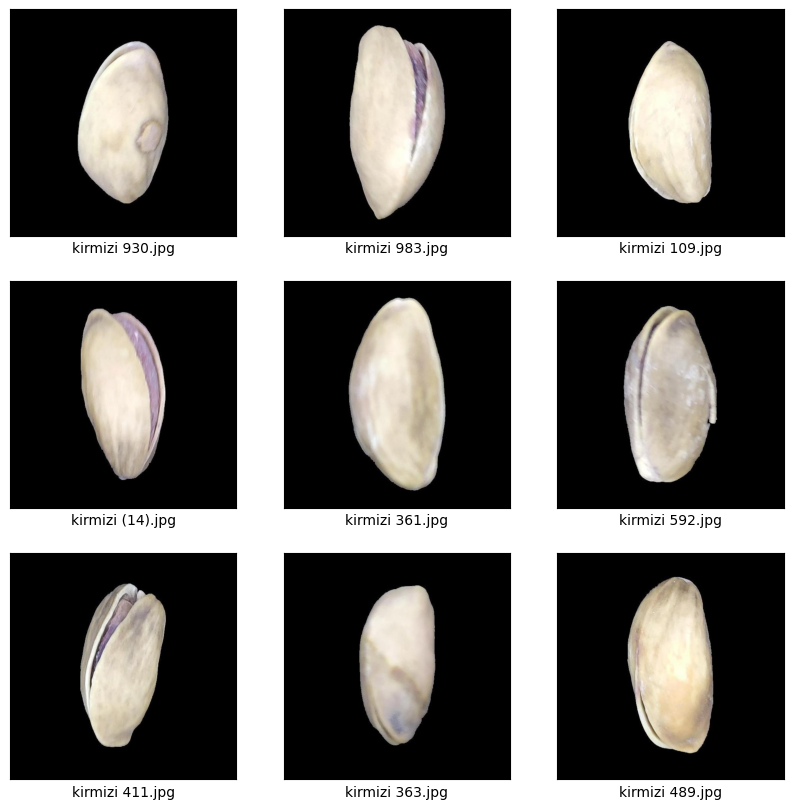

In [31]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = np.random.choice(Krimize_images)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(img_path.name)
plt.show()

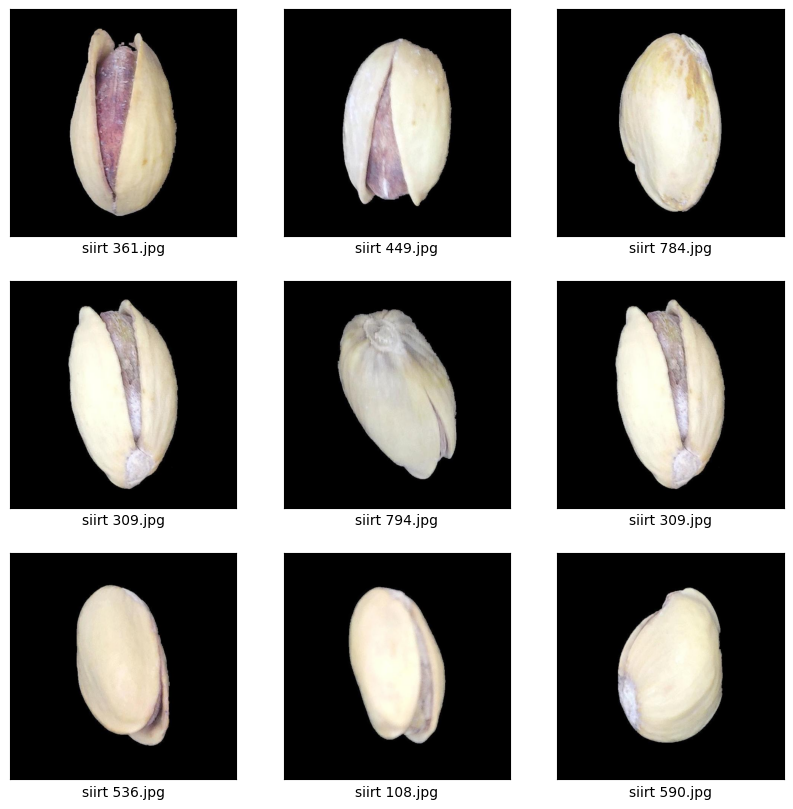

In [32]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = np.random.choice(Siirt_images)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(img_path.name)
plt.show()

In [33]:
Dataset = Krimize_images + Siirt_images
np.random.shuffle(Dataset)
Dataset = pd.DataFrame(Dataset, columns=['image'])
Dataset['label'] = Dataset['image'].apply(lambda x : x.parent.name)

In [34]:
Dataset['label'].value_counts()


label
Kirmizi_Pistachio    1232
Siirt_Pistachio       916
Name: count, dtype: int64

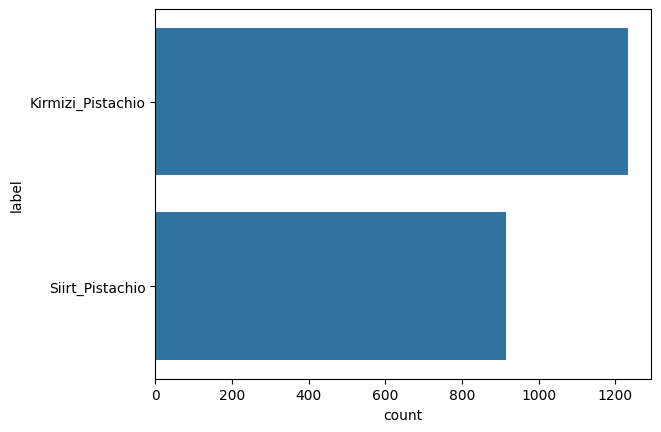

In [35]:
sns.countplot(Dataset['label'])
plt.show()

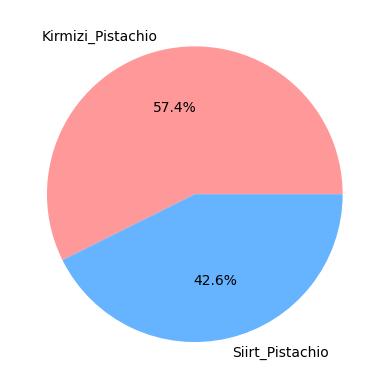

In [36]:
plt.pie(Dataset['label'].value_counts(), labels=Dataset['label'].value_counts().index, autopct='%1.1f%%',colors=['#ff9999','#66b3ff'])
plt.show()

In [37]:
train, test = train_test_split(Dataset, test_size=0.3, random_state=42, stratify=Dataset['label'])

In [38]:
train.shape


(1503, 2)

In [39]:
test.shape


(645, 2)

In [40]:
Train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
Test_datagen = ImageDataGenerator(rescale=1./255)

In [41]:
train['image'] = train['image'].astype(str)


In [42]:
train_generator = Train_datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32
)


Found 1503 validated image filenames belonging to 2 classes.


In [43]:
test['image'] = test['image'].astype(str)

In [44]:
test_generator = Test_datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32
)

Found 645 validated image filenames belonging to 2 classes.


In [45]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

c:\Users\My ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,123,201 (30.99 MB)

 Trainable params: 8,123,201 (30.99 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [48]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
checkpoint = ModelCheckpoint('model.keras', save_best_only=True)

In [49]:
history = model.fit(train_generator, validation_data=test_generator, epochs=50,callbacks=[reduce_lr,checkpoint])

Epoch 1/50


c:\Users\My ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 739ms/step - accuracy: 0.5737 - loss: 0.7462 - val_accuracy: 0.6636 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 710ms/step - accuracy: 0.6735 - loss: 0.5946 - val_accuracy: 0.7721 - val_loss: 0.5089 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 715ms/step - accuracy: 0.6796 - loss: 0.5625 - val_accuracy: 0.7860 - val_loss: 0.4719 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 739ms/step - accuracy: 0.7235 - loss: 0.5345 - val_accuracy: 0.8248 - val_loss: 0.4536 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 716ms/step - accuracy: 0.7673 - loss: 0.4949 - val_accuracy: 0.8000 - val_loss: 0.4922 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 745ms/step - accuracy: 0.7679 - loss: 0.4876 - val_accuracy: 0.8279 - val_loss: 0.4128 - learning_rate: 0.0010
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 723ms/step - accuracy: 0.8033 - loss: 0.4457 - val_

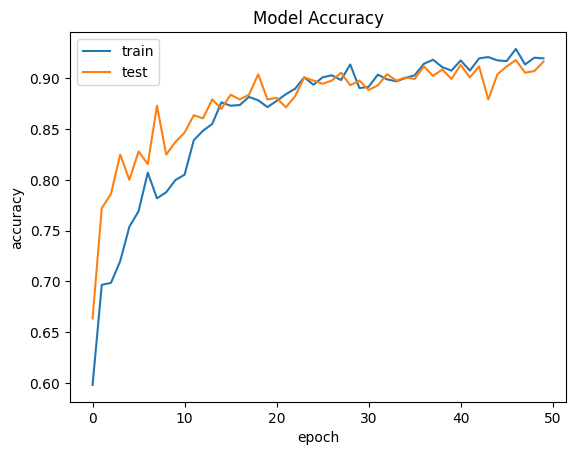

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()